<a href="https://colab.research.google.com/github/shivendr7/SatGAN/blob/master/EEGANtillEESN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

250257408/250242400 [==============================] - 73s 0us/step


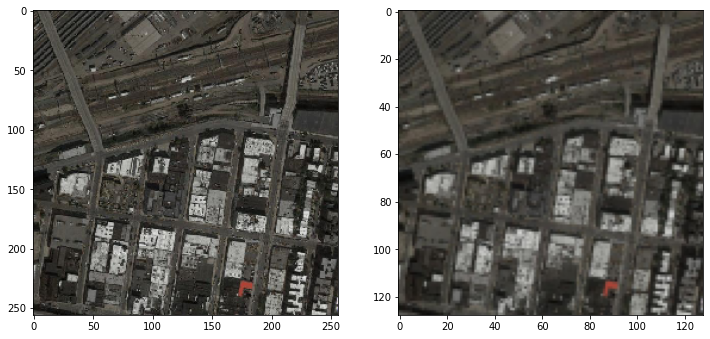

In [ ]:
import os
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.utils import get_file
from tensorflow.io import read_file
from skimage import data, color
from skimage.transform import resize
url='http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz'
path_to_zip=get_file('maps.tar.gz', origin=url, extract=True)
inside_train=listdir('/root/.keras/datasets/maps/train')
src_list=[]
full_path='/root/.keras/datasets/maps/train/'
for filename in inside_train:
  pixels=load_img(full_path+filename, target_size=(256,512))
  pixels=img_to_array(pixels)
  src_list.append(pixels[:,:256])
src_list=np.asarray(src_list)
resized_list=[]
for i in src_list:
  image=i
  image_resized = resize(image, (image.shape[0] // 2, image.shape[1] // 2),
                        anti_aliasing=True)
  resized_list.append(image_resized)
resized_list=np.array(resized_list)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(src_list[0].astype('uint8'))
plt.subplot(1,2,2)
plt.imshow(resized_list[0].astype('uint8'))

In [ ]:
resized_list=(resized_list-127.5)/127.5
src_list=(src_list-127.5)/127.5

In [ ]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Concatenate, Lambda, Subtract, Add, Activation, Reshape, Multiply, Flatten, Dropout, Dense, BatchNormalization, Permute
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.initializers import RandomNormal, Ones
import tensorflow as tf
from keras.losses import MeanSquaredError, MeanAbsolutePercentageError
import keras.backend as K
import numpy as np

In [ ]:
def dense_block(in_layer):
  init=RandomNormal(stddev=0.2)
  conv1=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(in_layer)
  conv11=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv12=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  conv13=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv1)
  concat1=Concatenate()([conv11, conv12, conv13])
  conv201=Concatenate()([concat1, conv11])
  conv202=Concatenate()([concat1, conv12])
  conv203=Concatenate()([concat1, conv13])
  conv21i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv201)
  conv22i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv202)
  conv23i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv203)
  conv21=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv21i)
  conv22=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv22i)
  conv23=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv23i)
  concat2=Concatenate()([conv21, conv22, conv23])
  conv301=Concatenate()([concat2, conv21i])
  conv302=Concatenate()([concat2, conv22i])
  conv303=Concatenate()([concat2, conv23i])
  conv31i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv301)
  conv32i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv302)
  conv33i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv303)
  conv31=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv31i)
  conv32=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv32i)
  conv33=Conv2D(filters=16, kernel_size=(3,3), padding='same', kernel_initializer='he_uniform', activation='relu')(conv33i)
  concat3=Concatenate()([conv31, conv32, conv33])
  conv401=Concatenate()([concat3, conv31i])
  conv402=Concatenate()([concat3, conv32i])
  conv403=Concatenate()([concat3, conv33i])
  conv41i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv401)
  conv42i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv402)
  conv43i=Conv2D(filters=16, kernel_size=(1,1), padding='same', kernel_initializer='he_uniform', activation='relu')(conv403)
  concat4=Concatenate()([conv41i, conv42i, conv43i])
  out_layer=Concatenate()([concat4, conv1])
  return out_layer

In [ ]:
inp=Input(shape=(28,28,1))
m=Model(inputs=inp, outputs=dense_block(inp))
#plot_model(m)

In [ ]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.nn.depth_to_space(x, scale)

    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

In [ ]:
def build_udsn(image_shape):
  inp=Input(shape=image_shape)
  db1=dense_block(inp)
  con=Concatenate()([db1, db1])
  db2=dense_block(con)
  con=Concatenate()([db1, db2, db2])
  db3=dense_block(con)
  con=Concatenate()([db1, db2, db3, db3])
  db4=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db4])
  db5=dense_block(con)
  con=Concatenate()([db1, db2, db3, db4, db5, db5])
  db6=dense_block(con)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(db6)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  LR=Conv2D(filters=12, kernel_size=(3,3), padding='same')(sub_net)
  LR=LeakyReLU(alpha=0.02)(LR)
  Ibase=SubpixelConv2D(LR.shape, scale=2)(LR)
  Ibase=BatchNormalization(momentum=0.8)(Ibase)
  Ibase=Activation('tanh')(Ibase)
  model=Model(inputs=inp, outputs=Ibase)
  return model

In [ ]:
#eesn essentials
def meanfilter(shape, dtype=None):   #kernel to find mean of 3-channel pixel data
  f=np.array([
              [[[.3333],
                [.3333],
                [.33333]]]
  ])
  return K.variable(f, dtype='float32')
def laplacian(shape, dtype=None):   #laplacian kernel
  f=np.array([
      [[[-1]],[[-1]],[[-1]]],
      [[[-1]],[[ 8]],[[-1]]],
      [[[-1]],[[-1]],[[-1]]]
  ])
  return K.variable(f, dtype='float32')
def channel_thrice(shape, dtype=None):   #kernel to triplicate the single channel data
  f=np.array([
              [[[1, 1, 1]]]   #3 for three layers of filters
  ])
  return K.variable(f, dtype='float32')

In [ ]:
def build_eesn(Ibase_shape):
  inp=Input(shape=(Ibase_shape))
  bw=Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_initializer=meanfilter, trainable=False)(inp)  #no change recommended   
  Iedge=Conv2D(filters=1, kernel_size=(3,3), padding='same', kernel_initializer=laplacian, trainable=False)(bw)     #no change recommended
  Itrip=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Iedge)   #no change recommended
  
  sub=Subtract()([inp, Itrip])
  ee=Conv2D(filters=32, kernel_size=(3,3), padding='same', strides=(2,2))(Iedge)
  ee=Conv2D(filters=64, kernel_size=(3,3), padding='same')(ee)
  ee=Conv2D(filters=16, kernel_size=(1,1), padding='same')(ee)
  
  #dense net
  db=dense_block(ee)
  db=dense_block(db)
  db=dense_block(db)
  db=Conv2D(16, kernel_size=(3,3), padding='same')(db)

  #mask branch
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(ee)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=32, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Conv2D(filters=16, kernel_size=(3,3), padding='same')(mb)
  mb=LeakyReLU(alpha=0.02)(mb)
  mb=Activation('sigmoid')(mb)

  #transpose=Permute((2,1,3), input_shape=db.shape)(db)
  product=Multiply()([db, mb])  #multiplies element wise
  #con=Concatenate()([mb, db])
  #transpose2=Permute((2,1,3), input_shape=product.shape)(product)
  sub_net=Conv2D(filters=64, kernel_size=(4,4), padding='same', activation='relu', kernel_initializer='he_uniform')(product)
  sub_net=Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  sub_net=Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', kernel_initializer='he_uniform')(sub_net)
  ee=Conv2D(4, kernel_size=(3,3), padding='same')(sub_net)
  Istedge=SubpixelConv2D(ee.shape, scale=2)(ee)
  #Istedge=Conv2D(1, kernel_size=(3,3), padding='same')(Istedge)
  Istedge=Conv2D(filters=3, kernel_size=(1,1), padding='same', kernel_initializer=channel_thrice, trainable=False)(Istedge)  #no change recommended
  
  #Istedge=BatchNormalization()(Istedge)
  SR=Add()([Istedge, sub])
  SR=BatchNormalization()(SR)
  SR=Activation('tanh')(SR)
  
  model=Model(inputs=inp, outputs=SR)
  return model

In [ ]:
def consistency_loss(y_true, y_pred):
  lambd=5
  return charbonnier_penalty(y_true, y_pred)

mape=MeanAbsolutePercentageError()
def consistency_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  ISR=eesn(Ibase)
  model=Model(inputs=inp, outputs=ISR)
  opt=Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='mse', optimizer=opt)
  return model

In [ ]:
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.0002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model

In [ ]:
udsn=build_udsn(image_shape=(128,128,3))
#plot_model(udsn)

In [ ]:
eesn=build_eesn(Ibase_shape=(256,256,3))
#plot_model(eesn)

In [ ]:
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()

In [ ]:
cons_model=consistency_model(img_shape=(128,128,3))
#cons_model.summary()

In [ ]:
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc

In [ ]:
def train_consistency_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]

  loss, acc=cons_model.train_on_batch(input_batch, HR_batch), 0
  return loss, acc

In [ ]:
for i in range(1000):
  print(i, train_charbonnier_model(1), train_consistency_model(1))

0 (47.50277328491211, 0) (0.2128140777349472, 0)
1 (45.57609176635742, 0) (0.08481210470199585, 0)
2 (68.48715209960938, 0) (0.19961035251617432, 0)
3 (57.46571350097656, 0) (0.09933286905288696, 0)
4 (31.179744720458984, 0) (0.13278919458389282, 0)
5 (38.47187805175781, 0) (0.13328978419303894, 0)
6 (70.82826232910156, 0) (0.1581704020500183, 0)
7 (77.00835418701172, 0) (0.20207476615905762, 0)
8 (47.19325256347656, 0) (0.1637968122959137, 0)
9 (34.95111846923828, 0) (0.1177545115351677, 0)
10 (27.495861053466797, 0) (0.12640663981437683, 0)
11 (49.729736328125, 0) (0.16698773205280304, 0)
12 (39.91447448730469, 0) (0.22084198892116547, 0)
13 (44.95996856689453, 0) (0.13157576322555542, 0)
14 (74.13247680664062, 0) (0.15908142924308777, 0)
15 (41.51096725463867, 0) (0.14335545897483826, 0)
16 (51.65970993041992, 0) (0.24248987436294556, 0)
17 (58.08604049682617, 0) (0.08598947525024414, 0)
18 (17.9384708404541, 0) (0.11649245023727417, 0)
19 (63.86604690551758, 0) (0.10140164196491241

In [ ]:
"""
from keras.applications.vgg16 import VGG16
vgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)
vgg.trainable=False
#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)
"""

"\nfrom keras.applications.vgg16 import VGG16\nvgg=VGG16(weights='imagenet', input_shape=(256,256,3), include_top=False)\nvgg.trainable=False\n#resize_layer=Conv2D(filters=3, kernel_size=(33,33), kernel_initializer=Ones(), trainable=False)\n"

In [ ]:
"""
def charbonnier_penalty(y_true, y_pred):
  epsilon=0.001 #compensation parameter
  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)
  #return K.mean(K.square(y_true- y_pred) + epsilon**2)

def charbonnier_model(img_shape):
  inp=Input(shape=img_shape)
  Ibase=udsn(inp)
  #resize_Ibase=resize_layer(Ibase)
  out=vgg(Ibase*127.5+127.5)
  model=Model(inputs=inp, outputs=out)
  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)
  model.compile(loss='mse', optimizer=opt)
  return model
"""

"\ndef charbonnier_penalty(y_true, y_pred):\n  epsilon=0.001 #compensation parameter\n  return K.mean(Subtract()([y_true, y_pred])**2 + epsilon**2)\n  #return K.mean(K.square(y_true- y_pred) + epsilon**2)\n\ndef charbonnier_model(img_shape):\n  inp=Input(shape=img_shape)\n  Ibase=udsn(inp)\n  #resize_Ibase=resize_layer(Ibase)\n  out=vgg(Ibase*127.5+127.5)\n  model=Model(inputs=inp, outputs=out)\n  opt=Adam(learning_rate=0.002, beta_1=0.5, clipnorm=1)\n  model.compile(loss='mse', optimizer=opt)\n  return model\n"

In [ ]:
"""
charb=charbonnier_model(img_shape=(128,128,3))
#charb.summary()
"""

'\ncharb=charbonnier_model(img_shape=(128,128,3))\n#charb.summary()\n'

In [ ]:
"""
def train_charbonnier_model(n_batch):
  ix=np.random.randint(0, 1096, n_batch)
  input_batch=resized_list[ix]
  HR_batch=src_list[ix]
  #input_batch=input_batch*127.5+127.5
  HR_batch=HR_batch*127.5+127.5
  #extracting HR Image features through VGG
  #HR_resized=resize_layer(HR_batch)
  ground_feat=vgg(HR_batch)

  #print(input_batch.shape)
  
  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0
  return loss, acc
"""

'\ndef train_charbonnier_model(n_batch):\n  ix=np.random.randint(0, 1096, n_batch)\n  input_batch=resized_list[ix]\n  HR_batch=src_list[ix]\n  #input_batch=input_batch*127.5+127.5\n  HR_batch=HR_batch*127.5+127.5\n  #extracting HR Image features through VGG\n  #HR_resized=resize_layer(HR_batch)\n  ground_feat=vgg(HR_batch)\n\n  #print(input_batch.shape)\n  \n  loss, acc=charb.train_on_batch(input_batch, ground_feat), 0\n  return loss, acc\n'

In [ ]:
"""
for i in range(100):
  print(train_charbonnier_model(1))
"""

'\nfor i in range(100):\n  print(train_charbonnier_model(1))\n'

Text(0.5, 1.0, 'IHR')

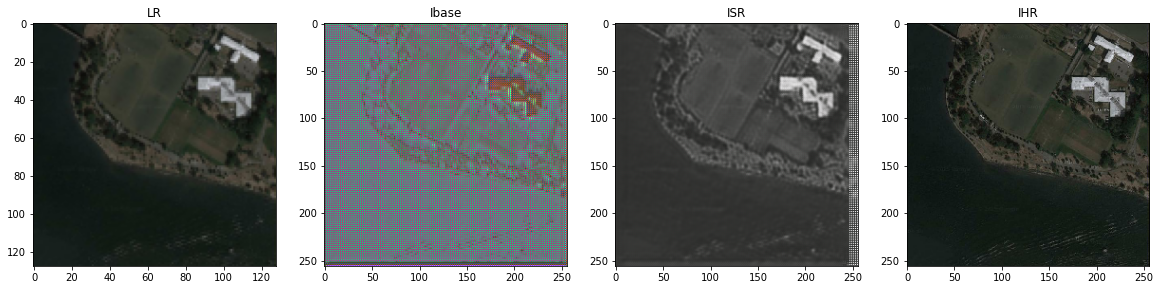

In [ ]:
ix=np.random.randint(0, 1096, 1)
ILR=resized_list[ix]
IHR=src_list[ix]
Ibase=udsn(ILR)
ISR=eesn(Ibase)

plt.figure(figsize=(20, 80))

plt.subplot(1,4,1)
ILR=ILR*127.5+127.5
plt.imshow(ILR.reshape(128,128,3).astype('uint8'))
plt.title('LR')

plt.subplot(1,4,2)
Ibase1=Ibase*127.5+127.5
plt.imshow(np.array(Ibase1).reshape(256,256,3).astype('uint8'))
plt.title('Ibase')

plt.subplot(1,4,3)
ISR1=ISR*127.5+127.5
plt.imshow(np.array(ISR1).reshape(256,256,3).astype('uint8'))
plt.title('ISR')

plt.subplot(1,4,4)
plt.imshow((IHR*127.5+127.5).reshape(256,256,3).astype('uint8'))
plt.title('IHR')

In [ ]:
#vgg(Ibase)

In [ ]:
Ibase*127.5+127.5

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[ 68.03821 , 136.39041 , 147.48969 ],
         [154.77728 , 108.44683 ,  78.512405],
         [ 64.604935, 102.20615 , 212.11449 ],
         ...,
         [ 69.150795,  66.643875,  35.262108],
         [ 66.795166,  66.58715 ,  36.015564],
         [ 69.75772 ,  66.385704,  34.92144 ]],

        [[ 69.410515,  65.2628  ,  34.566994],
         [ 69.692856,  66.62045 ,  65.43853 ],
         [ 68.780304,  65.75095 ,  34.48062 ],
         ...,
         [ 68.57721 ,  66.18599 ,  99.07695 ],
         [ 68.459114,  67.43373 ,  86.72263 ],
         [ 69.20926 ,  66.60203 ,  47.643974]],

        [[ 66.50321 ,  96.79161 , 115.76238 ],
         [157.4114  ,  66.788635, 139.29718 ],
         [ 61.8543  ,  66.62558 , 197.96587 ],
         ...,
         [132.38988 ,  65.74063 ,  34.606827],
         [ 66.32164 ,  65.90946 ,  35.447502],
         [116.47712 ,  65.926956,  34.824646]],

        ...,

        [[238.95276 , 203.3092  , 

In [ ]:
ISR1

<tf.Tensor: shape=(1, 256, 256, 3), dtype=float32, numpy=
array([[[[110.09898 , 114.22291 , 114.4596  ],
         [116.85481 , 113.98178 , 111.680214],
         [102.6414  , 104.760574, 110.98889 ],
         ...,
         [168.69756 , 168.9982  , 167.07413 ],
         [131.40619 , 131.51932 , 129.23592 ],
         [134.11328 , 134.05501 , 131.73137 ]],

        [[136.5962  , 136.51335 , 134.25467 ],
         [133.63474 , 133.59058 , 133.15833 ],
         [133.40189 , 133.35818 , 131.0422  ],
         ...,
         [ 84.57161 ,  84.14578 ,  85.42906 ],
         [156.20798 , 156.49341 , 157.40794 ],
         [101.03096 , 100.718765,  99.08619 ]],

        [[111.73945 , 113.54256 , 114.26318 ],
         [108.49632 , 102.92497 , 106.82628 ],
         [ 98.99396 ,  99.10167 , 106.50453 ],
         ...,
         [223.1399  , 221.85208 , 221.05927 ],
         [103.73011 , 103.5727  , 101.24776 ],
         [153.79471 , 151.0923  , 148.94275 ]],

        ...,

        [[147.00526 , 145.09946 , 

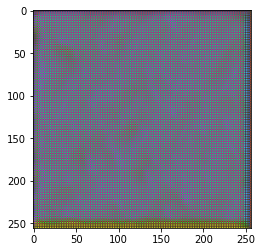

In [ ]:
plt.imshow(np.array(Ibase*127.5+127.5).reshape(256,256,3).astype('uint8'))

In [ ]:
Ibase.shape

TensorShape([1, 256, 256, 3])